In [95]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [341]:
class Value():
    def __init__(self, data, _children=(), label="", _op=""): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._op  = _op
        self.label = label
        self._prev = set(_children)
        
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op="+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out 


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op="*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other 

    def __truediv__(self, other):
        return self * other ** -1 

    def __rtruediv__(self, other): 
        return other * self**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "exponent has to be int of float"
        out = Value(self.data ** other, (self, ), _op=f"**{other}")
        def _backward():
            self.grad += (other*(self.data**(other-1))) * out.grad
        out._backward = _backward
        return out
    
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), _op="tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build(child)
                topo.append(root)
        
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [74]:
from graphviz import Digraph
diam = Digraph(format="svg", graph_attr={"rankdir":"LR"})

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    diam = Digraph(format="svg", graph_attr={"rankdir":"LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        diam.node(name=uid, label="{%s | data %.4f | grad %.4f} " %(n.label, n.data, n.grad), shape="record")
        if n._op:
            diam.node(name=uid + n._op, label=n._op)
            diam.edge(uid + n._op, uid)
    
    for n1, n2 in edges: 
        diam.edge(str(id(n1)), str(id(n2)) + n2._op)
    return diam

Example with a neuron

In [92]:
# inputs valeus
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.88137, label="b")

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
L = x1w1_x2w2 + b; L.label = "L"
c = (2*L).exp()
o = (c-1)/(c+1)


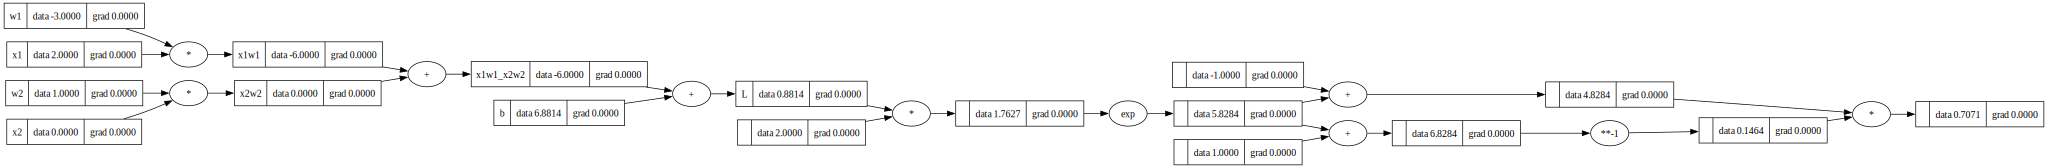

In [93]:
draw_dot(o)

In [81]:
o.backward()

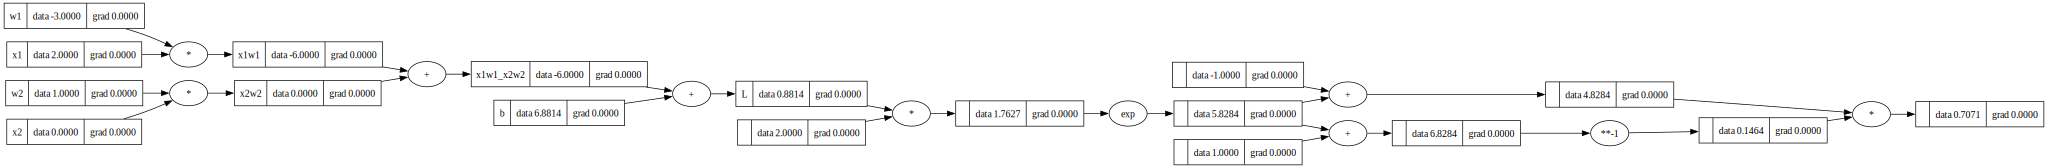

In [94]:
draw_dot(o)

MLP from scratch

In [368]:
class Neuron():
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(low=-1.0, high=1.0)) for _ in range(nin)]
        self.b = Value(0) # Value(np.random.uniform(low=-1.0, high=1.0))
    
    def __call__(self, x):
        act = sum([xi*wi for xi, wi in zip(x, self.w)], self.b)
        act.tanh()
        return act
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer():
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x) # calling layer sequentially
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [369]:
# we want 3 inputs and 2 hidden layers with 4 neurons and 1 output
n = MLP(3, [4, 4, 1]) 
len(n.parameters())
# to calculate the number of params manually for each neuron: 
# (n_input_layer_before) * num_neorns + bias

41

In [370]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0], 
    ]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(-2.132707830351572),
 Value(-0.18168504532362761),
 Value(-0.29472554544752994),
 Value(-0.9830324840469045)]

In [371]:
for i in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yp - ysi)**2 for ysi, yp in zip(ys, ypred))
    
    # backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data -= p.grad*0.005 # 0.01 is the step size
        
    print(i, loss.data)


AttributeError: 'int' object has no attribute 'data'

In [365]:
ypred = [n(x) for x in xs]
ypred

[Value(1.9867669156191337),
 Value(-1.3779861020650257),
 Value(0.35589340414978654),
 Value(0.6177037775404853)]